

# Linear Regression to predict stock prices



In [2]:
! pip install yfinance
! pip install ta

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import yfinance as yf
import ta

warnings.filterwarnings("ignore")

# Option sûre pour le style
plt.style.use('seaborn-v0_8')  # ou remplace par un style présent dans plt.style.available


In [5]:
import matplotlib as mpl
from matplotlib import cycler
import matplotlib.pyplot as plt


colors = cycler('color',
                ['#669FEE', '#66EE91', '#9988DD',
                 '#EECC55', '#88BB44', '#FFBBBB'])
plt.rc('figure', facecolor='#313233')
plt.rc('axes', facecolor="#313233", edgecolor='none',
       axisbelow=True, grid=True, prop_cycle=colors,
       labelcolor='gray')
plt.rc('grid', color='474A4A', linestyle='solid')
plt.rc('xtick', color='gray')
plt.rc('ytick', direction='out', color='gray')
plt.rc('legend', facecolor="#313233", edgecolor="#313233")
plt.rc("text", color="#C9C9C9")
plt.rc('figure', facecolor='#313233')

# How a Liner Regression algorithm works theorically


# Predict stock prices using a Linear Regression


### Import the data from Yahoo (esiest choice)


In [10]:
# Import the data
df = yf.download("GOOG")

# Take adjusted close
df = df[["Close"]]

# Rename the column
df.columns = ["close"]
df

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


,close
Date,
2004-08-19,2.484366
2004-08-20,2.681699
2004-08-23,2.708686
2004-08-24,2.596526
2004-08-25,2.624504
...,...
2025-06-10,180.009995
2025-06-11,178.789993
2025-06-12,176.970001


### Features Engineering



In [13]:
def feature_engineering(df):
    """ Create new variables"""
    
    # We copy the dataframe to avoid interferences in the data
    df_copy = df.dropna().copy()
    
    # Create the returns
    df_copy["returns"] = df_copy["close"].pct_change(1)

    # Create the SMAs
    df_copy["SMA 15"] = df_copy[["close"]].rolling(15).mean().shift(1)
    df_copy["SMA 60"] = df_copy[["close"]].rolling(60).mean().shift(1)
    
    # Create the volatilities
    df_copy["MSD 10"] = df_copy[["returns"]].rolling(10).std().shift(1)
    df_copy["MSD 30"] = df_copy[["returns"]].rolling(30).std().shift(1)
    
    # Create the Rsi
    RSI = ta.momentum.RSIIndicator(df_copy["close"], window= 14, fillna = False)
    df_copy["rsi"] = RSI.rsi()
    
    return df_copy.dropna()

In [15]:
dfc = feature_engineering(df)
dfc

,close,returns,SMA 15,SMA 60,MSD 10,MSD 30,rsi
Date,,,,,,,
2004-11-12,4.506223,-0.005573,4.523208,3.372128,0.045158,0.045223,60.962966
2004-11-15,4.577283,0.015769,4.539005,3.405826,0.045046,0.045295,62.484304
2004-11-16,4.271998,-0.066696,4.534829,3.437419,0.044225,0.045283,52.938982
2004-11-17,4.271008,-0.000232,4.519544,3.463474,0.048354,0.047390,52.910756
2004-11-18,4.148201,-0.028754,4.497310,3.491382,0.048425,0.047302,49.392429
...,...,...,...,...,...,...,...
2025-06-10,180.009995,0.013399,170.996697,162.846483,0.015606,0.021217,66.808346
2025-06-11,178.789993,-0.006777,171.819466,163.056337,0.014171,0.021181,64.414716
2025-06-12,176.970001,-0.010179,172.730697,163.263336,0.014393,0.021241,60.908810


### Create different sets of data

In [18]:
dfc.columns

Index(['close', 'returns', 'SMA 15', 'SMA 60', 'MSD 10', 'MSD 30', 'rsi'], dtype='object')

In [20]:
# Percentage train set
split = int(0.80*len(dfc))

# Train set creation
X_train = dfc[['SMA 15', 'SMA 60', 'MSD 10', 'MSD 30', 'rsi']].iloc[:split]
y_train = dfc[["returns"]].iloc[:split]


# Test set creation
X_test = dfc[['SMA 15', 'SMA 60', 'MSD 10', 'MSD 30', 'rsi']].iloc[split:]
y_test = dfc[["returns"]].iloc[split:]

### Linear Regression training

In [23]:
# Import the class
from sklearn.linear_model import LinearRegression

# Initialize the class
reg = LinearRegression()

# Fit the model
reg.fit(X_train, y_train)

LinearRegression()

### Linear Regression predictions

<Axes: xlabel='Date'>

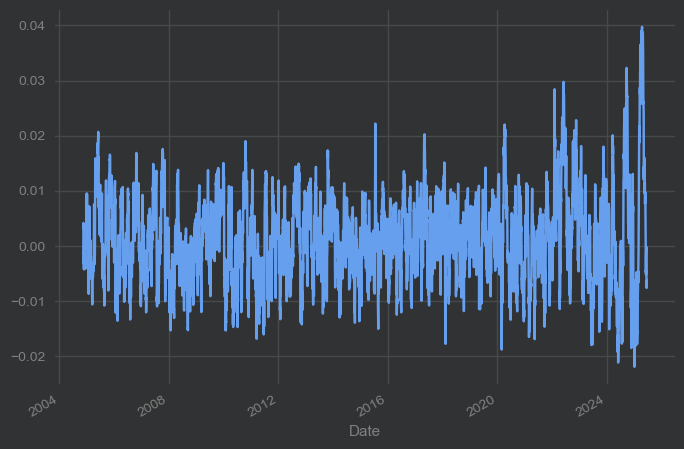

In [26]:
# Create predictions for the whole dataset
X = np.concatenate((X_train, X_test), axis=0)

dfc["prediction"] = reg.predict(X)

# We verify that the algorithm doesn't predict only way (positive or negative)
dfc["prediction"].plot()

### Compute the profit 

<Axes: xlabel='Date'>

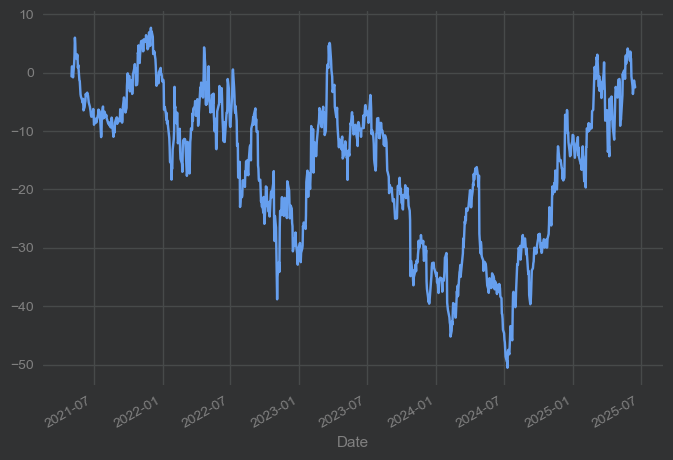

In [29]:
# Compute the position
dfc["position"] = np.sign(dfc["prediction"])

# Compute the returns
dfc["strategy"] = dfc["returns"] * dfc["position"].shift(1)


(dfc["strategy"].iloc[split:].cumsum()*100).plot()

In [31]:
def lin_reg_trading(symbol):

  def feature_engineering(df):
    """ Create new variables"""
    
    # We copy the dataframe to avoid interferences in the data
    df_copy = df.dropna().copy()
    
    # Create the returns
    df_copy["returns"] = df_copy["close"].pct_change(1)

    # Create the SMAs
    df_copy["SMA 15"] = df_copy[["close"]].rolling(15).mean().shift(1)
    df_copy["SMA 60"] = df_copy[["close"]].rolling(60).mean().shift(1)
    
    # Create the volatilities
    df_copy["MSD 10"] = df_copy[["returns"]].rolling(10).std().shift(1)
    df_copy["MSD 30"] = df_copy[["returns"]].rolling(30).std().shift(1)
    
    # Create the Rsi
    RSI = ta.momentum.RSIIndicator(df_copy["close"], window= 14, fillna = False)
    df_copy["rsi"] = RSI.rsi()
    
    return df_copy.dropna()
  

  # Import the data
  df = yf.download(symbol)

  # Take adjusted close
  df = df[["Close"]]

  # Rename the column
  df.columns = ["close"]

  dfc = feature_engineering(df)

  # Percentage train set
  split = int(0.80*len(dfc))

  # Train set creation
  X_train = dfc[['SMA 15', 'SMA 60', 'MSD 10', 'MSD 30', 'rsi']].iloc[:split]
  y_train = dfc[["returns"]].iloc[:split]


  # Test set creation
  X_test = dfc[['SMA 15', 'SMA 60', 'MSD 10', 'MSD 30', 'rsi']].iloc[split:]
  y_test = dfc[["returns"]].iloc[split:]

  # Import the class
  from sklearn.linear_model import LinearRegression

  # Initialize the class
  reg = LinearRegression()

  # Fit the model
  reg.fit(X_train, y_train)

  # Create predictions for the whole dataset
  X = np.concatenate((X_train, X_test), axis=0)

  dfc["prediction"] = reg.predict(X)

  # Compute the position
  dfc["position"] = np.sign(dfc["prediction"])

  # Compute the returns
  dfc["strategy"] = dfc["returns"] * dfc["position"].shift(1)


  (dfc["strategy"].iloc[split:].cumsum()*100).plot()

[*********************100%***********************]  1 of 1 completed


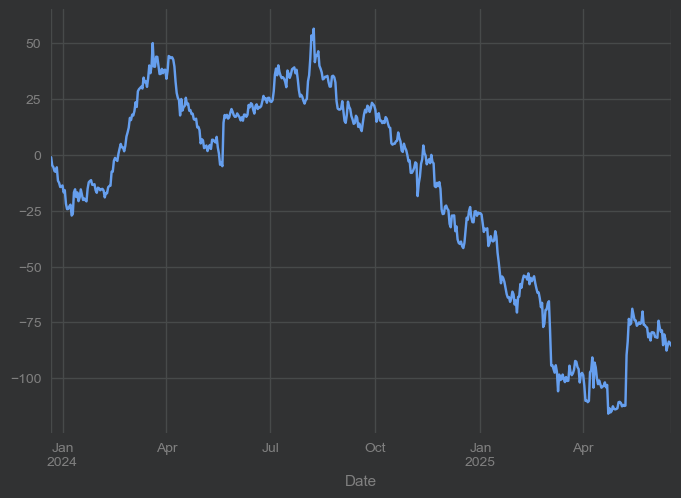

In [33]:
lin_reg_trading("ETH-EUR")